In [1]:
import io, requests, glob, os, math
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA


In [2]:
# Plot a parameter of a dataframe
def plot_param(params, title, data, log=False):
    params = params if type(params) in (tuple, list) else [params]
    maxDate = data["Datum"].max()
    fig, axs = plt.subplots(5, 2, figsize=(20, 20), constrained_layout=True)
    fig.suptitle(
        f'{title} bis {maxDate.strftime("%d. %b %Y")}',
        fontweight="bold", fontsize="xx-large")
    i = 0

    # Name is the name of the Bundesland. Create a figure for each country.
    for bl in data["Name"].unique():
        data_bl = data.loc[data["Name"] == bl]
        # Figure order: 0  1
        #               2  3 ...
        axis = axs[int(i / 2), i % 2]
        axis.xaxis.set_major_locator(mdates.MonthLocator())
        axis.xaxis.set_minor_locator(
            mdates.WeekdayLocator(byweekday=mdates.MO))
        axis.set_title(bl,
                       fontweight="bold" if bl == "Österreich" else "normal")
        j = 0
        secondAxis = axis.twinx() if len(params) > 1 else None
        # Draw a line for each parameter
        for param in params:
            currentAxis = axis if j == 0 else secondAxis
            if log:
                currentAxis.set_yscale('log')

            res = STL(data_bl.loc[:, param], period=7).fit()
            if j == 0:
                currentAxis.plot(res.observed, linewidth=1)
                currentAxis.plot(res.trend)
            else:
                currentAxis.plot(res.trend, color="black", linewidth=1)
            j = j + 1
        axis.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
        axis.grid(True, which="minor", axis="x")
        axis.grid(True, which="major", axis="y")
        i = i + 1
        if bl == "Österreich":
            for a in ['top', 'bottom', 'left', 'right']:
                axis.spines[a].set_linewidth(2)
            #plt.rc("figure", figsize=(16, 8))
            #res.plot()
    plt.show()
    fig.savefig(f'{title}_{dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d%H%M%S")}.png', facecolor="white", dpi=96)


In [3]:

requests.packages.urllib3.disable_warnings()
requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS += 'HIGH:!DH:!aNULL'

# To avoid ssl error (key to short) we use requests.get
req = requests.get(
    "https://info.gesundheitsministerium.gv.at/data/timeline-faelle-bundeslaender.csv", verify=False)

# Read the result in a dataframe
data = pd.read_table(
    io.StringIO(req.content.decode("utf-8-sig")),
    sep=";", header=0, parse_dates=[0])

# Calculate the diff values. We have 10 Countries (9 + Austria in general)
# so the last value is 10 lines above.
data["TestungenPCRTaeglich"] = data["TestungenPCR"].diff(periods=10)
data["HospitalisierungTaeglich"] = data["Hospitalisierung"].diff(periods=10)
data["Neuinfektionen"] = data["BestaetigteFaelleBundeslaender"].diff(
    periods=10)
data["Positivrate"] = data.apply(lambda row: np.nan if row["TestungenPCRTaeglich"] == 0 else row["Neuinfektionen"] * 100000 / row["TestungenPCRTaeglich"], axis=1)
# Subtract 1 day (values are published on the next day in the morning)
data["Datum"] = pd.to_datetime(data["Datum"], utc=True).dt.date + pd.DateOffset(days=-1)
for bl in data["Name"].unique():
    for param in ["TestungenPCRTaeglich", "HospitalisierungTaeglich", "Hospitalisierung", "Neuinfektionen", "Positivrate"]:
        mean = data.loc[data["Name"] == bl, param].mean()
        stdev = data.loc[data["Name"] == bl, param].std()
        minVal = 0 if (param == "TestungenPCRTaeglich" or param ==
                       "Neuinfektionen" or param == "Positivrate") else -math.inf
        #maxVal = mean + 5 * stdev
        data.loc[(data["Name"] == bl) & ((data[param] < minVal)), param] = np.nan
        data.loc[data["Name"] == bl, param] = data.loc[data["Name"] == bl, param].interpolate(method="linear")

    # Fill na values for first diff.
    data.loc[data["Name"] == bl] = data.loc[data["Name"] == bl].fillna(method="bfill")
data.to_csv("timeline-faelle-bundeslaender.csv", encoding='utf-8', index=False)


In [4]:
data = pd.read_csv("timeline-faelle-bundeslaender.csv",
                   encoding='utf-8', parse_dates=[0])
data.set_index("Datum", drop=False, inplace=True)
for file in glob.glob('*.png'):
    os.remove(file)


## Neuinfektionen

Die Neuinfektionen zeigen eine Abhängigkeit vom Wochentag, da am Wochenende weniger getestet wird. Zudem werden die Schultests an bestimmten Tagen durchgeführt.

In [5]:
neuinfektionen = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "Neuinfektionen": data.tail(7*10)["Neuinfektionen"],
    }
)
neuinfektionen["NeuinfektionenPrint"] = neuinfektionen.apply(lambda x: f'{x.Neuinfektionen:,.0f}'.replace(",", " "), axis=1)
neuinfektionen.pivot(values="NeuinfektionenPrint", columns="Name")


Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-01-16,237,611,2 385,2 270,1 428,1 172,2 100,747,4 767,15 717
2022-01-17,237,685,2 678,3 002,1 333,1 362,2 123,907,4 358,16 685
2022-01-18,362,815,4 044,3 315,2 771,2 398,3 702,1 109,9 161,27 677
2022-01-19,580,1 165,3 852,4 580,2 237,2 365,2 983,1 402,5 150,24 314
2022-01-20,509,1 138,3 731,4 743,2 327,2 289,3 032,1 050,6 527,25 346
2022-01-21,464,1 272,3 489,4 258,2 383,3 091,2 973,1 075,5 255,24 260
2022-01-22,577,1 725,3 938,3 414,1 887,2 326,2 667,1 062,4 857,22 453


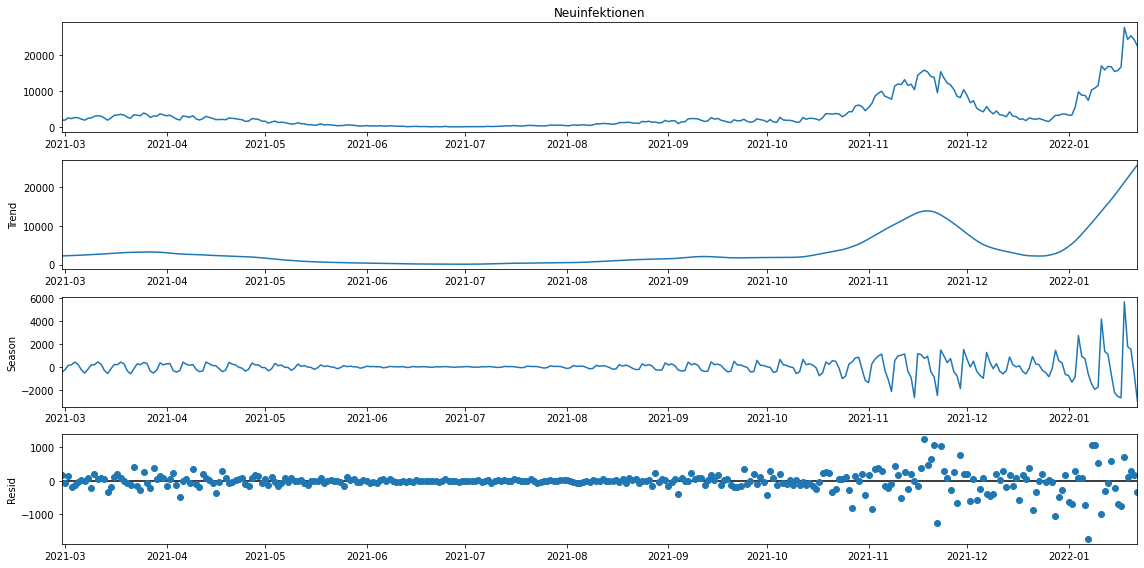

In [6]:
decomposed = STL(data.loc[data["Name"] == "Österreich", "Neuinfektionen"], period=7).fit()
plt.rc("figure", figsize=(16, 8))
decomposed.plot()
plt.show()


### Neuinfektionen (Vorausberechnung)

In [7]:
infektionen = data.loc[data["Name"] == "Österreich", "Neuinfektionen"].tail(15)
fcst = STLForecast(infektionen, ARIMA, period=7, model_kwargs={"order": (2, 1, 0)}).fit().forecast(7)
pd.DataFrame(fcst.apply(lambda x: f'{x:,.0f}'.replace(",", " ")), columns = ["Neuinfektionen"])

C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


,Neuinfektionen
2022-01-23,23 506
2022-01-24,24 482
2022-01-25,35 335
2022-01-26,31 821
2022-01-27,32 609
2022-01-28,31 244
2022-01-29,28 892


## Hospitalisierung
### Werte der letzten 7 Tage

In [8]:
hosp = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "Hospitalisierung": data.tail(7*10)["Hospitalisierung"],
        "Diff": data.tail(8*10)["Hospitalisierung"].diff(periods=10).tail(7*10)
    }
)
hosp["HospitalisierungPrint"] = hosp.apply(lambda x: f'{x.Hospitalisierung:,.0f} ({x.Diff:,.0f})'.replace(",", " "), axis=1)
hosp.pivot(values="HospitalisierungPrint", columns="Name")


Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-01-16,37 (2),88 (13),117 (9),97 (4),55 (-3),87 (1),127 (14),28 (-3),298 (14),934 (51)
2022-01-17,38 (1),110 (22),137 (20),103 (6),65 (10),100 (13),134 (7),32 (4),293 (-5),1 012 (78)
2022-01-18,38 (0),108 (-2),132 (-5),129 (26),66 (1),122 (22),130 (-4),39 (7),298 (5),1 062 (50)
2022-01-19,39 (1),115 (7),149 (17),126 (-3),71 (5),115 (-7),123 (-7),45 (6),306 (8),1 089 (27)
2022-01-20,44 (5),113 (-2),144 (-5),128 (2),73 (2),118 (3),130 (7),50 (5),308 (2),1 108 (19)
2022-01-21,45 (1),100 (-13),152 (8),125 (-3),75 (2),119 (1),126 (-4),48 (-2),336 (28),1 126 (18)
2022-01-22,47 (2),98 (-2),168 (16),133 (8),80 (5),104 (-15),120 (-6),47 (-1),332 (-4),1 129 (3)


### Diagramm

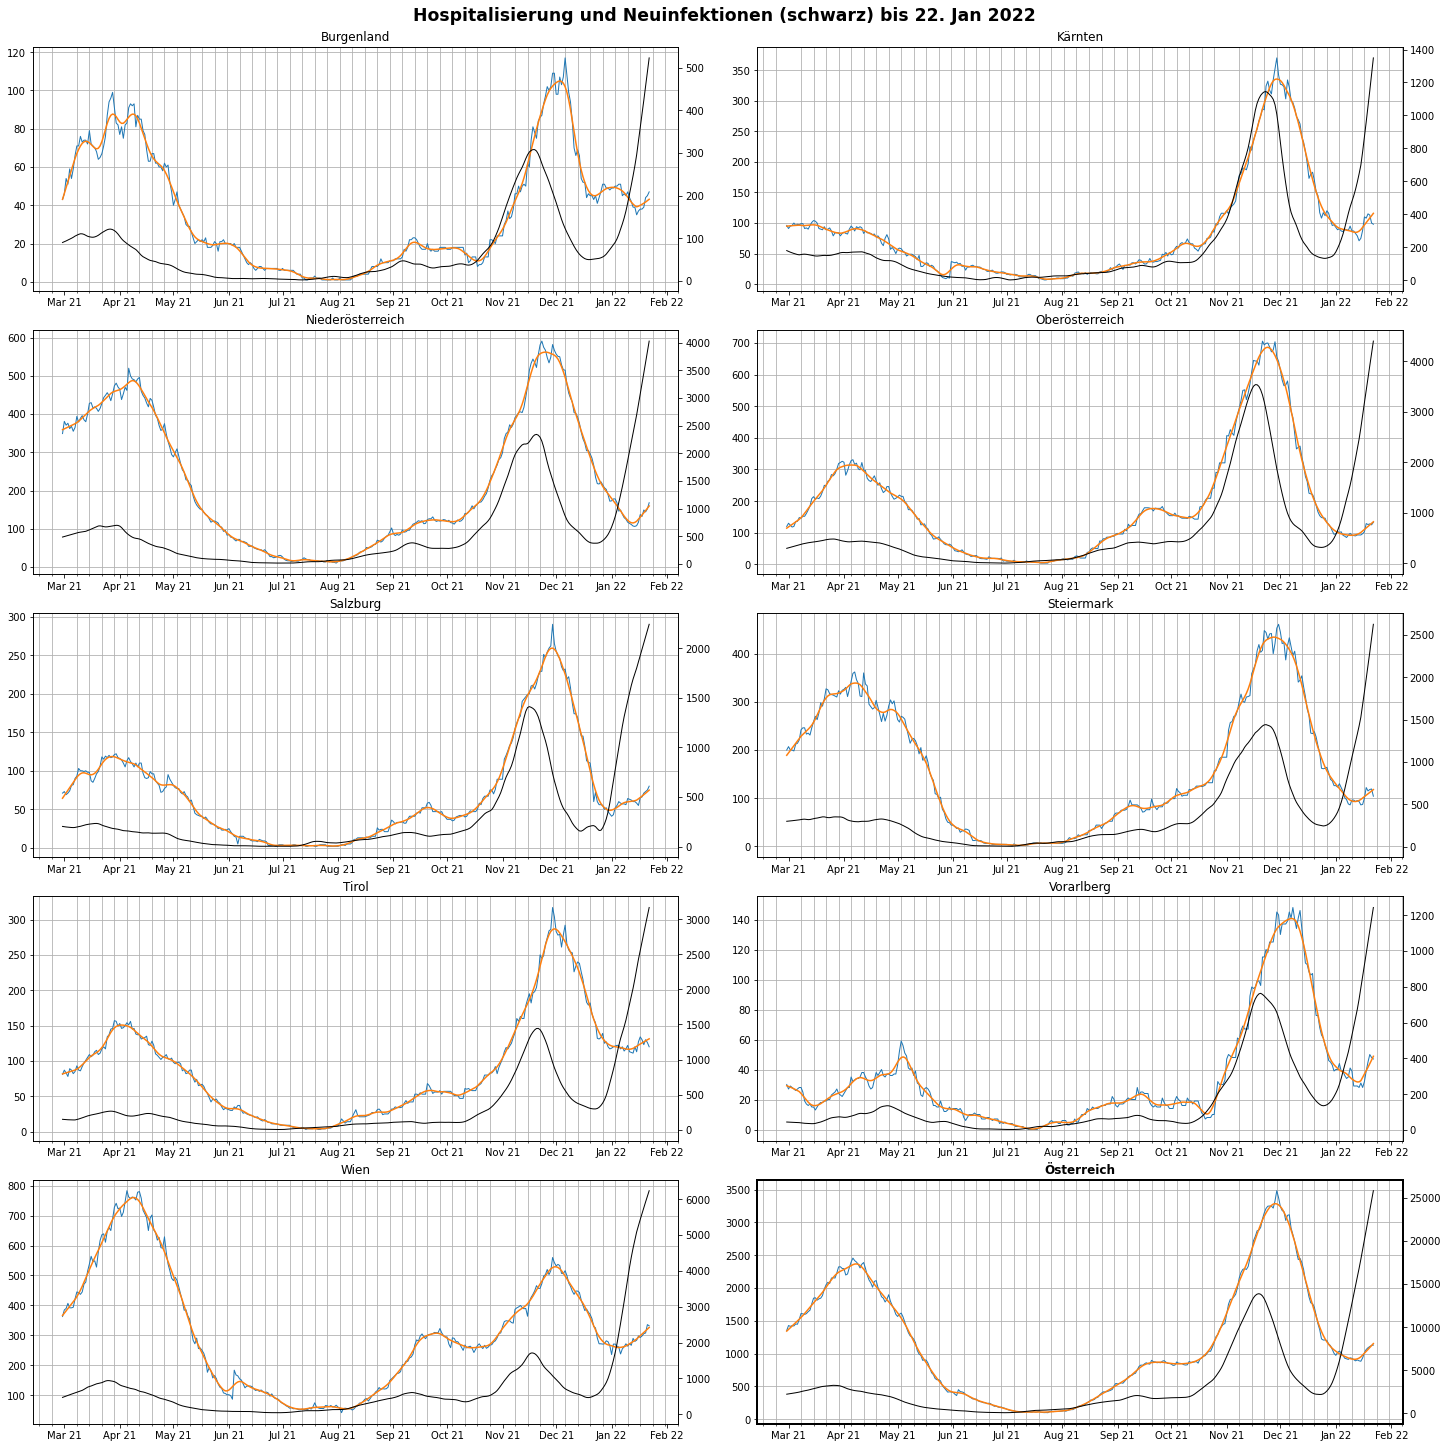

In [9]:

plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (schwarz)", data)


### Logarithmischer Plot

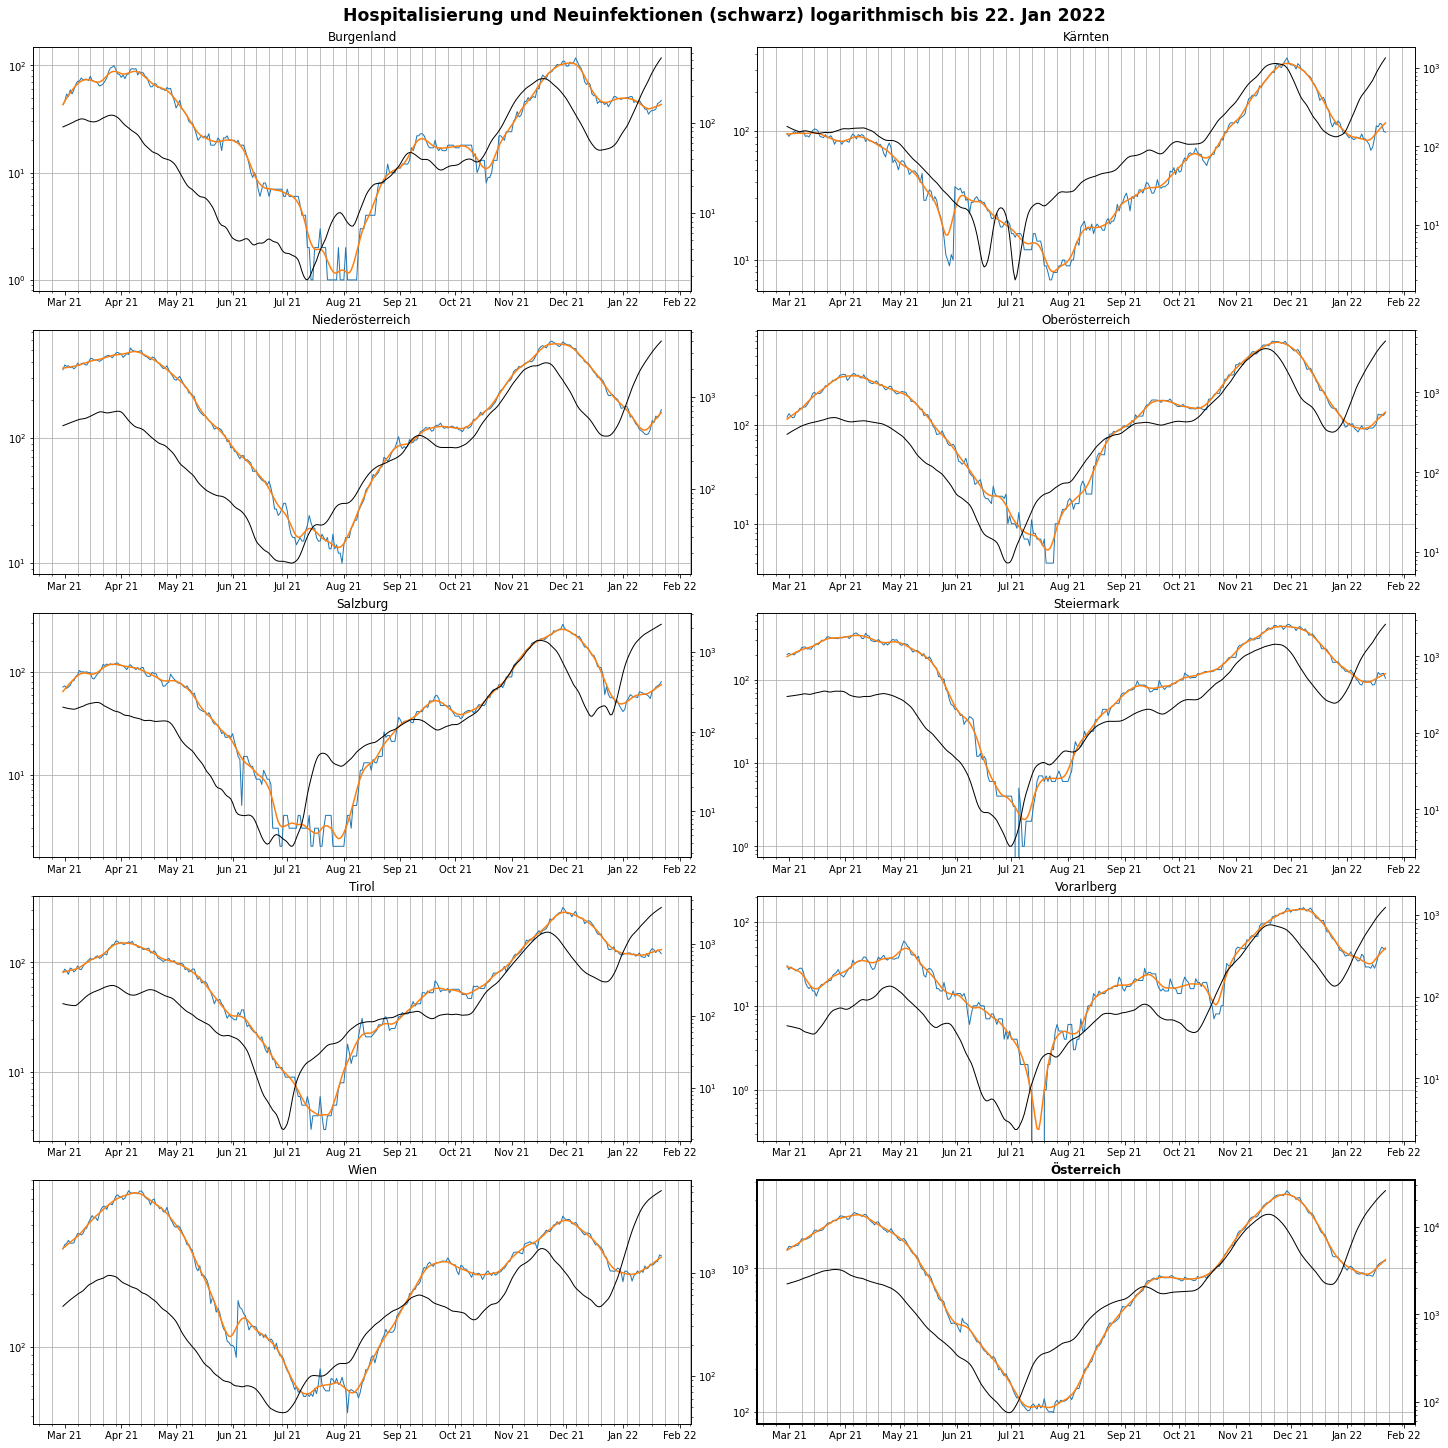

In [10]:
plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (schwarz) logarithmisch", data, log=True)

## Durchgeführte PCR Tests
### Werte der letzten 7 Tage

In [11]:
pcrTaeglich = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "TestungenPCRTaeglich": data.tail(7*10)["TestungenPCRTaeglich"],
        "Diff": data.tail(8*10)["TestungenPCRTaeglich"].diff(periods=10).tail(7*10)
    }
)
pcrTaeglich["TestungenPrint"] = pcrTaeglich.apply(lambda x: f'{x.TestungenPCRTaeglich:,.0f} ({x.Diff:,.0f})'.replace(",", " "), axis=1)
pcrTaeglich.pivot(values="TestungenPrint", columns="Name")

Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-01-16,9 135 (-2 758),11 710 (6 073),31 759 (3 981),48 633 (7 188),19 142 (-909),13 597 (-17 092),18 602 (-7 840),9 349 (2 440),223 274 (5 895),385 201 (-3 022)
2022-01-17,5 529 (-3 606),3 713 (-7 997),40 382 (8 623),37 446 (-11 187),8 145 (-10 997),41 484 (27 887),24 952 (6 350),6 622 (-2 727),276 943 (53 669),445 216 (60 015)
2022-01-18,16 872 (11 343),15 754 (12 041),26 524 (-13 858),61 547 (24 101),31 410 (23 265),40 238 (-1 246),26 531 (1 579),12 284 (5 662),411 089 (134 146),642 249 (197 033)
2022-01-19,7 161 (-9 711),5 844 (-9 910),210 585 (184 061),33 555 (-27 992),19 958 (-11 452),30 951 (-9 287),27 899 (1 368),9 577 (-2 707),299 569 (-111 520),645 099 (2 850)
2022-01-20,11 313 (4 152),11 392 (5 548),18 870 (-191 715),54 610 (21 055),15 241 (-4 717),30 951 (0),26 447 (-1 452),9 326 (-251),388 260 (88 691),566 410 (-78 689)
2022-01-21,11 387 (74),12 801 (1 409),43 429 (24 559),33 813 (-20 797),26 364 (11 123),40 650 (9 699),24 490 (-1 957),8 631 (-695),268 756 (-119 504),470 321 (-96 089)
2022-01-22,17 059 (5 672),10 464 (-2 337),37 710 (-5 719),47 762 (13 949),18 312 (-8 052),23 494 (-17 156),23 486 (-1 004),7 939 (-692),233 260 (-35 496),419 486 (-50 835)


### Diagramm

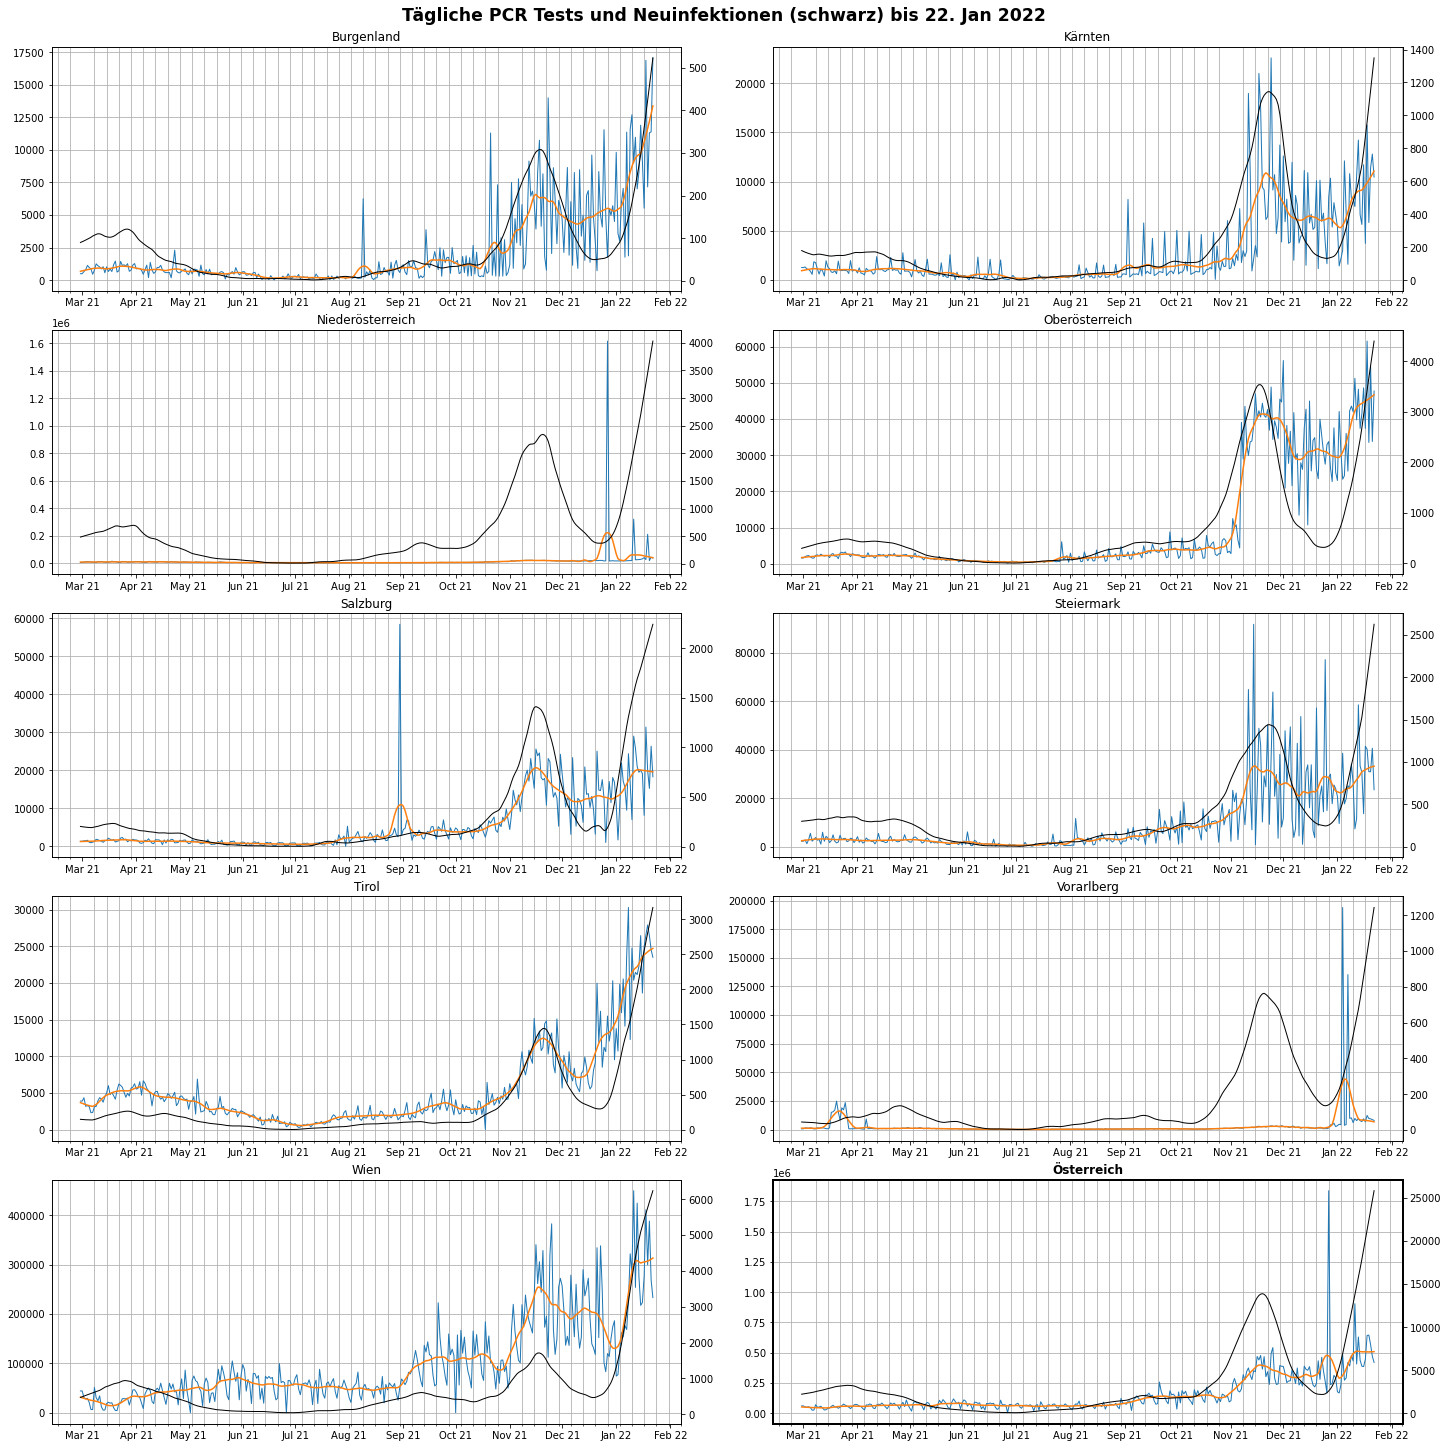

In [12]:

plot_param(["TestungenPCRTaeglich", "Neuinfektionen"], "Tägliche PCR Tests und Neuinfektionen (schwarz)", data)
